# TFRecords制作

为了高效地读取数据，可以将数据进行序列化存储，这样也便于网络流式读取数据。TFRecord是一种比较常用的存储二进制序列数据的方法

- 加速网络的训练，存取数据更快了
- 把处理好的数据，存储为TFRecord格式，方便多次训练

tf.Example类是一种将数据表示为{"string": value}形式的meassage类型，Tensorflow经常使用tf.Example来写入、读取TFRecord数据

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf

## tf.Example中可以使用以下几种格式：

- tf.train.BytesList: 可以使用的类型包括 string和byte
- tf.train.FloatList: 可以使用的类型包括 float和double
- tf.train.Int64List: 可以使用的类型包括 enum,bool, int32, uint32, int64

### 转化实例

In [2]:
# 准备3个函数
def _bytes_feature(value):
    """Returns a bytes_list from a string/byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    # 转换成BytesList
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Return a float_list form a float/double."""
    # 转换成FloatList
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Return a int64_list from a bool/enum/int/uint."""
    # 转换成Int64List
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [3]:
# tf.train.BytesList
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_string'.encode('utf8')))

# tf.train.FloatList
print(_float_feature(np.exp(1)))

# tf.train.Int64List
print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_string"
}

float_list {
  value: 2.7182817
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



## TFRecord制作方法

### 创建tf.Example

In [4]:
# 不同类型数据，可以使用不同类型的格式
def serialize_example(feature0, feature1, feature2, feature3):
    """
    创建tf.Example
    """
    
    # 转换成相应类型
    feature = {
        'feature0': _int64_feature(bool(feature0)),
        'feature1': _int64_feature(int(feature1)),
        'feature2': _bytes_feature(feature2),
        'feature3': _float_feature(feature3),
    }
    # 使用tf.train.Example来创建
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    # SerializeToString方法转换为二进制字符串
    return example_proto.SerializeToString()

In [5]:
# 
example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?'

In [6]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876
      }
    }
  }
}

### 数据示例

In [7]:
# 数据量
n_observations = int(1e4)

# 随机创建10000条，False或True
feature0 = np.random.choice([False, True], n_observations)

# 随机整数
feature1 = np.random.randint(0, 5, n_observations)

# 随机字符串
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# 随机浮点类型
feature3 = np.random.randn(n_observations)

### 写入TFRecord文件

In [8]:
# 起名字，要保存的文件名字
filename = 'tfrecord-1'
# 4个feature写入文件
with tf.io.TFRecordWriter(filename) as writer:
    for i in range(n_observations):
        example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
        writer.write(example)

### 加载TFRecord文件

In [9]:
filenames = [filename]
# 读取
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [10]:
for raw_record in raw_dataset.take(5):
    print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04N\x85$\xbf'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xbc\xa5\x90\xbe'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nS\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x03\n\x15\n\x08feature2\x12\t\n\x07\n\x05horse\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x91`\xb2\xbd'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xfbd\x1c@'>
<tf.Tensor: shape=(), dtype=string, nu

## 图像数据处理实例

In [11]:
import os
import glob
from datetime import datetime
# pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### 看一下图片

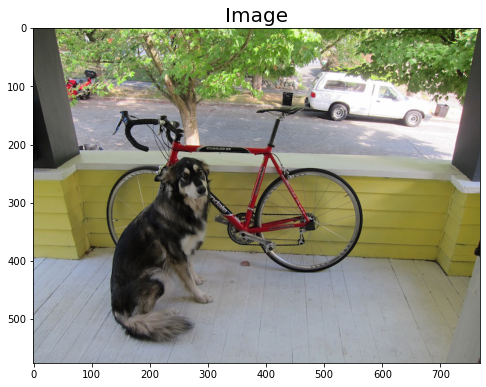

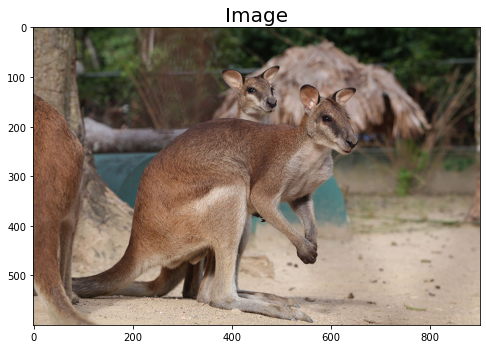

In [12]:
image_path = './img/'
images = glob.glob(image_path + '*.jpg')

for fname in images:
    image = mpimg.imread(fname)
    f, (ax1) = plt.subplots(1, 1, figsize=(8,8))
    f.subplots_adjust(hspace = .2, wspace = .05)
    
    ax1.imshow(image)
    ax1.set_title('Image', fontsize=20)
    
plt.style.use('classic')
plt.show()

In [13]:
image_labels = {
    'dog': 0,
    'kangaroo': 1,
}

### 制作TFRecord

In [14]:
# 读数据，binary格式
image_string = open('./img/dog.jpg', 'rb').read()
label = image_labels['dog']

In [15]:
def _bytes_feature(value):
    """Returns a bytes_list from a string/byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Return a float_list form a float/double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Return a int64_list from a bool/enum/int/uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# 创建图像数据的Example
def image_example(image_string, label):
    image_shape = tf.image.decode_jpeg(image_string).shape

    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [26]:
# 打印部分信息
image_example_proto = image_example(image_string, label)

for line in str(image_example_proto).split('\n')[:50]:
    print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 600
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\377\330\377\341\000$Exif\000\000II*\000\010\000\000\000\001\000\230\202\002\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\377\354\000\021Ducky\000\001\000\004\000\000\000<\000\000\377\341\003\224http://ns.adobe.com/xap/1.0/\000<?xpacket begin=\"\357\273\277\" id=\"W5M0MpCehiHzreSzNTczkc9d\"?> <x:xmpmeta xmlns:x=\"adobe:ns:meta/\" x:xmptk=\"Adobe XMP Core 5.3-c011 66.145661, 2012/02/06-14:56:27        \"> <rdf:RDF xmlns:rdf=\"http://www.w3.org/1999/02/22-rdf-syntax-ns#\"> <rdf:Description rdf:about=\"\" xmlns:xmpMM=\"http://ns.adobe.com/xap/1.0/mm/\" xmlns:stRef=\"http://ns.adobe.com/xap/1.0/sType/ResourceRef#\" xmlns:dc=\"http://purl.org/dc/elements/1.1/\" xmlns:xmp=\"http://ns.adobe.com/xap/

In [17]:
# 制作 `images.tfrecords`.

image_path = './img/'
images = glob.glob(image_path + '*.jpg')
record_file = 'images.tfrecord'
counter = 0

with tf.io.TFRecordWriter(record_file) as writer:
    for fname in images:
        with open(fname, 'rb') as f:
            image_string = f.read()
            label = image_labels[os.path.basename(fname).replace('.jpg', '')]
            
            # `tf.Example` 
            tf_example = image_example(image_string, label)
            
            # 将`tf.example` 写入 TFRecord 
            writer.write(tf_example.SerializeToString())
            
            counter += 1
            print('Processed {:d} of {:d} images.'.format(
                counter, len(images)))

print(' Wrote {} images to {}'.format(counter, record_file))

Processed 1 of 2 images.
Processed 2 of 2 images.
 Wrote 2 images to images.tfrecord


### 加载制作好的TFRecord

In [18]:
raw_train_dataset = tf.data.TFRecordDataset('images.tfrecord')
raw_train_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

### 解析序列化格式
example数据都进行了序列化，还需要解析以下之前写入的序列化string
- tf.io.parse_single_example(example_proto, feature_description)函数可以解析单条example

In [19]:
# 解析的格式需要跟之前创建example时一致
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

现在看起来仅仅完成了一个样本的解析，实际数据不可能一个个来写吧，可以定义一个映射规则map函数

In [20]:
# 单个读取
def parse_tf_example(example_proto):
    # 解析出来
    parsed_example = tf.io.parse_single_example(example_proto, image_feature_description)
    
    # 预处理
    x_train = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)
    x_train = tf.image.resize(x_train, (416, 416))
    x_train /= 255.

    lebel = parsed_example['label']
    y_train = lebel
    
    return x_train, y_train
# 使用map，读取全部内容，只需要传入读取单个的函数parse_tf_example
train_dataset = raw_train_dataset.map(parse_tf_example)
train_dataset

<MapDataset shapes: ((416, 416, 3), ()), types: (tf.float32, tf.int64)>

## 制作训练集 实际使用

In [21]:
num_epochs = 10
# 数据增强，repeat，10个数据
train_ds = train_dataset.shuffle(buffer_size=10000).batch(2).repeat(num_epochs)
train_ds

<RepeatDataset shapes: ((None, 416, 416, 3), (None,)), types: (tf.float32, tf.int64)>

In [22]:
for batch, (x, y) in enumerate(train_ds):
    print(batch, x.shape, y)

0 (2, 416, 416, 3) tf.Tensor([1 0], shape=(2,), dtype=int64)
1 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
2 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
3 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
4 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
5 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
6 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
7 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
8 (2, 416, 416, 3) tf.Tensor([1 0], shape=(2,), dtype=int64)
9 (2, 416, 416, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)


### 定义模型

In [23]:
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### 训练模型

In [25]:
model.fit(train_ds, epochs=num_epochs)

Epoch 1/10
10/10 [==============================] - 0s 40ms/step - loss: 53.9582 - accuracy: 0.7000
Epoch 2/10
10/10 [==============================] - 0s 29ms/step - loss: 1.6380 - accuracy: 0.9500
Epoch 3/10
10/10 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 34ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 33ms/step - loss: 0.0000